## Content:
1. [Training using unmodified Gaia DR2 parallax and no offset model](#Training-using-unmodified-Gaia-DR2-parallax-and-no-offset-model)
1. [Training using unmodified Gaia DR2 parallax and a constant offset model](#Training-using-unmodified-Gaia-DR2-parallax-and-a-constant-offset-model)
1. [Training using unmodified Gaia DR2 parallax and a offset model depending several possible parameters](#Training-using-unmodified-Gaia-DR2-parallax-and-a-offset-model-depending-several-possible-parameters)
1. [Minimal Constant Offset Toy Model Demo](#Minimal-Constant-Offset-Toy-Model-Demo)
1. [Minimal Constant Offset Toy Model Demo (PyTorch 1.0 equivalent)](#Minimal-Constant-Offset-Toy-Model-Demo-(PyTorch-1.0-equivalent))

# Training using unmodified Gaia DR2 parallax and no offset model

We use `ApogeeBCNN` model here

In [ ]:
import h5py
import numpy as np
import astropy.units as u

from astroNN.nn.losses import (
    mean_absolute_error,
    mean_error,
    mean_absolute_percentage_error,
)
from astroNN.models import ApogeeBCNN
from astroNN.nn.callbacks import ErrorOnNaN
from astroNN.gaia import mag_to_fakemag

with h5py.File("gaia_dr2_train.h5") as F:  # ensure the file will be cleaned up
    parallax = np.array(F["parallax"])
    parallax_error = np.array(F["parallax_err"])
    spectra = np.array(F["spectra"])
    Kcorr = np.array(F["corrected_K"])  # extinction corrected Ks

fakemag, fakemag_err = mag_to_fakemag(Kcorr, parallax * u.mas, parallax_error)

# training
bcnn_net = ApogeeBCNN()
bcnn_net.num_hidden = [164, 64]
bcnn_net.max_epochs = 40
bcnn_net.targetname = ["Ks-band fakemag"]
bcnn_net.callbacks = ErrorOnNaN()
bcnn_net.labels_norm_mode = 4  # scale label but not center it
bcnn_net._last_layer_activation = (
    "softplus"  # transform NN prediction to positive number only
)
bcnn_net.metrics = [mean_absolute_error, mean_error, mean_absolute_percentage_error]
bcnn_net.train(spectra, fakemag, labels_err=fakemag_err)
bcnn_net.save("astroNN_no_offset_model")

# Training using unmodified Gaia DR2 parallax and a constant offset model

We use `ApogeeDR14GaiaDR2BCNN` model here

In [ ]:
import h5py
import numpy as np

from astroNN.nn.losses import (
    mean_absolute_error,
    mean_error,
    mean_absolute_percentage_error,
)
from astroNN.models import ApogeeDR14GaiaDR2BCNN
from astroNN.nn.callbacks import ErrorOnNaN

with h5py.File("gaia_dr2_train.h5") as F:  # ensure the file will be cleaned up
    parallax = np.array(F["parallax"])
    parallax_error = np.array(F["parallax_err"])
    spectra = np.array(F["spectra"])
    Kcorr = np.array(F["corrected_K"])  # extinction corrected Ks

# since constant offset, give offset model featureless vectors
aux_data = np.ones((parallax.shape[0], 3))

# stack all data to the model (spectra, Ks_mag, featureless zeros vector) as input
training_data_final = np.hstack((spectra, np.expand_dims(Kcorr, axis=1), aux_data))

# training
bcnn_net = ApogeeDR14GaiaDR2BCNN()
bcnn_net.max_epochs = 40
bcnn_net.callbacks = ErrorOnNaN()
bcnn_net.labels_norm_mode = 4  # scale label but not center it
bcnn_net.num_hidden = [164, 64, 32, 16]
bcnn_net.metrics = [mean_absolute_error, mean_error, mean_absolute_percentage_error]
bcnn_net.train(training_data_final, parallax, labels_err=parallax_error)
bcnn_net.save("astroNN_constant_model")

# Training using unmodified Gaia DR2 parallax and a offset model depending several possible parameters

We use `ApogeeDR14GaiaDR2BCNN` model here

In [1]:
from astroNN.nn.losses import (
    mean_absolute_error,
    mean_error,
    mean_absolute_percentage_error,
)
from astroNN.models import ApogeeDR14GaiaDR2BCNN
from astroNN.nn.callbacks import ErrorOnNaN
from astroNN.gaia import mag_to_fakemag
import h5py
import numpy as np
import astropy.units as u
from astroNN.nn.numpy import median_absolute_percentage_error as mape

with h5py.File("gaia_dr2_train.h5") as F:  # ensure the file will be cleaned up
    parallax = np.array(F["parallax"])
    parallax_error = np.array(F["parallax_err"])
    spectra = np.array(F["spectra"])
    Kcorr = np.array(F["corrected_K"])  # extinction corrected Ks
    bp_rp = np.array(F["bp_rp"])
    phot_g_mean_mag = np.array(F["phot_g_mean_mag"])
    teff = np.array(F["NN_teff"])

    good_idx = (
        (bp_rp != -9999.0)
        & (phot_g_mean_mag != -9999.0)
        & (teff != -9999.0)
        & (parallax_error / parallax < 0.1)
    )

    parallax = parallax[good_idx]
    parallax_error = parallax_error[good_idx]
    spectra = spectra[good_idx]
    Kcorr = Kcorr[good_idx]
    bp_rp = bp_rp[good_idx]
    phot_g_mean_mag = phot_g_mean_mag[good_idx]
    teff = teff[good_idx]

# need to manually
phot_g_mean_mag_std = np.std(phot_g_mean_mag)
phot_g_mean_mag_mean = np.mean(phot_g_mean_mag)
norm_phot_g_mean_mag = (phot_g_mean_mag - phot_g_mean_mag_mean) / phot_g_mean_mag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
norm_bp_rp = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
norm_teff = (teff - teff_mean) / teff_std

# stack all the gaia data
aux_data = np.stack((norm_phot_g_mean_mag, norm_bp_rp, norm_teff)).T

# stack all data to the model (spectra, Ks_mag, whatever_to_model) as input
training_data_final = np.hstack((spectra, np.expand_dims(Kcorr, axis=1), aux_data))

# training
bcnn_net = ApogeeDR14GaiaDR2BCNN()
bcnn_net.max_epochs = 40
bcnn_net.callbacks = ErrorOnNaN()
bcnn_net.labels_norm_mode = 4  # scale label but not center it
bcnn_net.num_hidden = [164, 64, 32, 16]
bcnn_net.metrics = [mean_absolute_error, mean_error, mean_absolute_percentage_error]
bcnn_net.train(training_data_final, parallax, labels_err=parallax_error)
bcnn_net.save("astroNN_multivariate_model")

After saved the model, we need to do a few tweaks to make the model work properly
1. manually set the mean and std of the gaia input data
2. manually set the normalizatio mode after that

In [2]:
import json
import numpy as np

with open("astroNN_multivariate_model/astroNN_model_parameter.json", "r") as fp:
    data = json.load(fp)

std = np.ones(7518)
std[7515] = phot_g_mean_mag_std
std[7516] = bp_rp_std
std[7517] = teff_std

data["input_std"] = std.tolist()

mean = np.array(data["input_mean"])
mean[7515] = phot_g_mean_mag_mean
mean[7516] = bp_rp_mean
mean[7517] = teff_mean

data["input_mean"] = mean.tolist()
data["input_norm_mode"] = 2

with open("astroNN_multivariate_model/astroNN_model_parameter.json", "w") as fp:
    json.dump(data, fp, indent=4, sort_keys=True)

## Minimal Constant Offset Toy Model Demo

Below is just a toy model which is a minimal version of our constant offset model to let you better understand what is going on or do experiment with some make-up data

To plot mode, refer to: https://astronn.readthedocs.io/en/v1.0.0/quick_start.html#i-have-installed-pydot-ng-and-graphviz-but-still-fail-to-plot-the-model

Calibrated offset found:  -0.050010182 



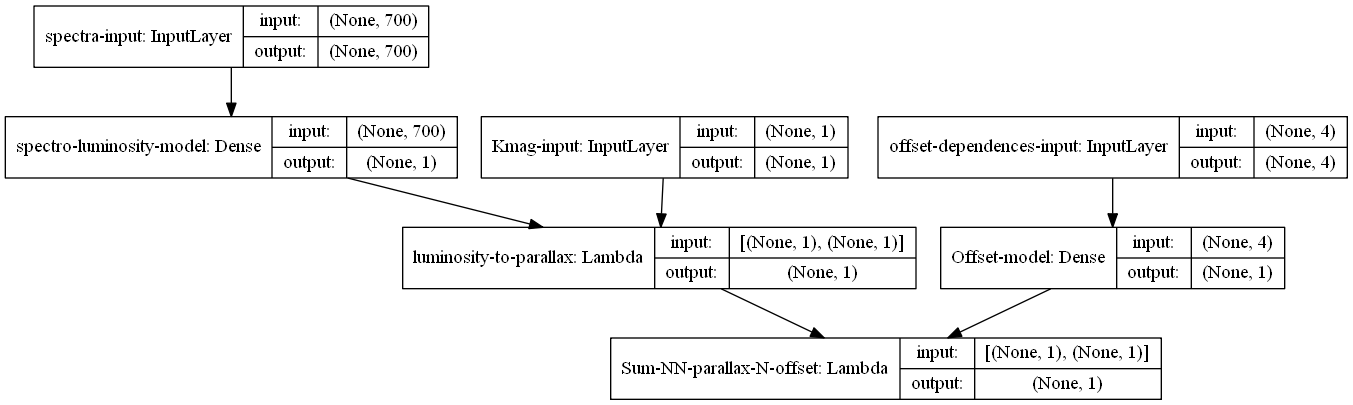

In [1]:
import tensorflow as tf
from IPython.display import Image
from astroNN.config import cpu_gpu_check

# check CPU GPU config first with astroNN
cpu_gpu_check()

# set the name
keras = tf.keras
Input, Dense, Lambda, Add = (
    keras.layers.Input,
    keras.layers.Dense,
    keras.layers.Lambda,
    keras.layers.Add,
)
Model = keras.models.Model
plot_model = keras.utils.plot_model
sgd = tf.keras.optimizers.SGD

true_offset = -0.05  # "gaia parallax offset ground turth"

# setup some random data
spectra = tf.random.normal((1000, 700), 0.0, 0.1)
K_mag = tf.random.normal((1000,), 10.0, 2.0)
Lmin = tf.math.log(
    1 + tf.math.exp(spectra[:, 100])
)  # lets say luminosity is just softplus activated of the 100th spectra flux
g_parallax = (Lmin * tf.math.pow(10.0, (-0.2 * K_mag))) + true_offset  # "gaia parallax"
offset_input = tf.ones((1000, 4))  # featureless vector of 1s

# all the input tensor
inputs = Input(shape=(700,), name="spectra-input")
inputs_mag = Input(shape=(1,), name="Kmag-input")
inputs_offset = Input(shape=(4,), name="offset-dependences-input")

# model
luminosity = Dense(1, activation="softplus", name="spectro-luminosity-model")(
    inputs
)  # spectroscopic luminosity
luminosity_to_parallax = Lambda(
    lambda mag: tf.math.multiply(
        mag[0], tf.math.pow(10.0, tf.math.multiply(-0.2, mag[1]))
    ),
    name="luminosity-to-parallax",
)([luminosity, inputs_mag])  # spectroscopic luminosity to parallax with K-mag
offset = Dense(1, activation="tanh", name="Offset-model")(
    inputs_offset
)  # offset calibrated by offset calibration model
preds = Lambda(lambda x: tf.math.add(x[0], x[1]), name="Sum-NN-parallax-N-offset")(
    [luminosity_to_parallax, offset]
)  # spectro-photometric parallax + offset
model = Model(inputs=[inputs, inputs_mag, inputs_offset], outputs=preds)  # setup model
model_offset = Model(inputs=inputs_offset, outputs=offset)  # setup offset model

sgd = sgd(learning_rate=0.01)  # setup optimizer
model.compile(optimizer=sgd, loss="mse", metrics=["mse"])
model.fit(
    [spectra, K_mag, offset_input],
    g_parallax,
    epochs=60,
    shuffle=True,
    verbose=0,
    steps_per_epoch=1000 // 64,
)

print(
    "Calibrated offset found: ",
    model_offset.predict(offset_input, steps=1).mean(),
    "\n",
)

plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file="minimal_constant_offset_model.png",
)
Image(filename="minimal_constant_offset_model.png")

## Minimal Constant Offset Toy Model Demo (equivalent model in PyTorch 1.0)

Below is just a toy model which is a minimal version of our constant offset model implemented in pure PyTorch 1.0, to let PyTorch user better understand what is going on or do experiment with some make-up data.

**The following code is just for PyTorch 1.0 user reference, I will not maintain or solve any programming issue you might have because Tensorflow is recommended**

In [2]:
import torch
import torch.nn.functional as F
from torch.distributions import Normal

true_offset = -0.05  # "gaia parallax offset ground turth"

# setup some random data
spectra = Normal(0.0, 0.1).sample((1000, 700))
K_mag = Normal(10.0, 2.0).sample((1000, 1))
Lmin = torch.log(
    1 + torch.exp(spectra[:, 100])
)  # lets say luminosity is just softplus activated of the 100th spectra flux
g_parallax = (Lmin * torch.pow(10.0, (-0.2 * K_mag))) + true_offset  # "gaia parallax"
offset_input = torch.ones((1000, 4))  # featureless vector of 1s


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 2 models hidden
        self.luminosity = torch.nn.Linear(700, 1)  # spectroscopic luminosity
        self.offset = torch.nn.Linear(
            4, 1, bias=False
        )  # offset calibrated by offset calibration model

    def forward(self, x):
        # parse inputs
        spectra = x[0]
        Kmag = x[1]
        offset_dep = x[2]

        luminosity = F.softplus(self.luminosity(spectra))
        luminosity_2_parallax = torch.mul(
            luminosity, torch.pow(10.0, torch.mul(-0.2, Kmag))
        )
        offset = torch.tanh(self.offset(offset_dep))

        return luminosity_2_parallax + offset

    def offset_sample(self, x):
        # parse inputs
        offset = torch.tanh(self.offset(x))

        return offset


net = Net()

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

for t in range(30):  # optimization
    prediction = net([spectra, K_mag, offset_input])  # input x and predict based on x

    loss = loss_func(prediction, g_parallax)  # must be (1. nn output, 2. target)

    optimizer.zero_grad()  # clear gradients for next train
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients

print(
    "Calibrated offset found: ",
    torch.mean(net.offset_sample(offset_input)).detach().numpy(),
    "\n",
)

Calibrated offset found:  -0.049758315 

